In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
training.head()
#Name and Ticket parameters are useless
#Ill map Sex into binary variable
#probably Cabin also 1 - had the Cabin 0 - didnt have 

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
training.info()
#there a quite a lot of missing Age values 
#Ill try to neglect It or fil missing values with median or mean but I think
#this may led to some quirks in data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


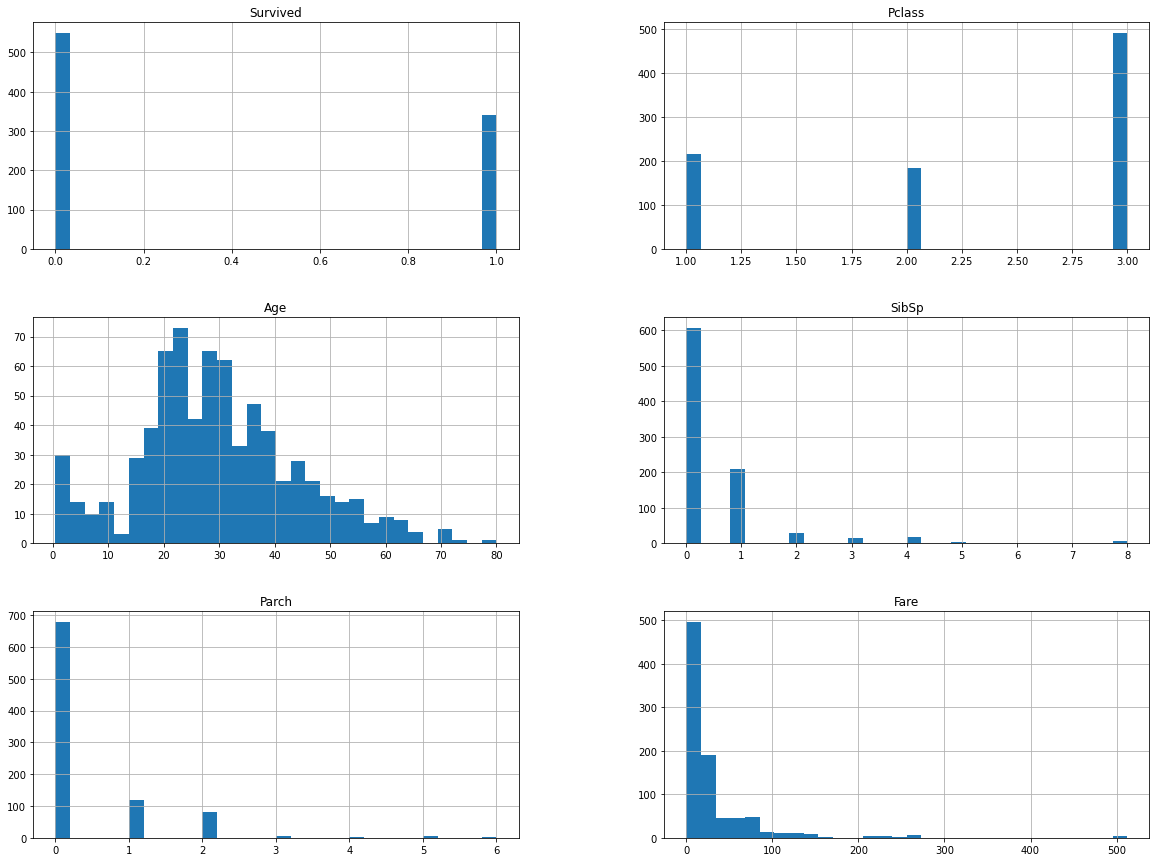

In [5]:
training.drop("PassengerId", axis=1).hist(bins=30, figsize = (20,15))
plt.show()

In [6]:
training_no_age = training.dropna(subset=["Age"]) #I put into test one with missing values filled with median
#and then i tried with missing values deleted and I got better result with deleted ones.
training_no_emb = training.dropna(subset=["Embarked"]) #lets try with this one

In [50]:
X_train = training_no_age.drop(["Survived"], axis = 1)
y_train = training_no_age["Survived"].copy()
#dividing set into instances and labels

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

#I tried to make age an categorical attribute but It seems that It do not work good
#maybe if I oneHotEncode it it would be better
def group_of_age(x):
    if x < 15:
        return 1
    elif x < 30:
        return 2
    elif x < 45:
        return 3
    elif x < 60:
        return 4
    elif x < 75:
        return 5
    else: return 6
    
#From Sex and cabin attribute I make binary ones
class Sex_cabin(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        sex = (X["Sex"] == "male").astype(np.int8)
        cabin = X["Cabin"].copy()
        #print(type(cabin[0]))
        for i in range(len(cabin)):
            cabin.iloc[i] = 0 if type(cabin.iloc[i]) == type(0.1) else 1
        
        return np.c_[sex,cabin]
    
#I make 2 additional attributes instead of SibSp and Parch I merge them
#and create binary attribute whether someone were alone or not on the board
class Relatives(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        relatives_on_board = X["SibSp"] + X["Parch"]
        alone = (relatives_on_board == 0).astype(np.int8)
        
        return np.c_[relatives_on_board,alone]
    
#Here I make age categorical attribute
class Age_cat(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        age = X.copy()
        for i in range(len(age)):
            age[i] = group_of_age(X[i])
           
        return age
#sexCabin = Sex_cabin()
#print(sexCabin.transform(X_train
#print(type(Age_cat))
relatives = Relatives()
print(relatives.transform(X_train))

[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [52]:
#Creating full pipeline 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
num_attribs = ["Fare","Age"]
#age = ["Age"] 
relatives_attribs = ["SibSp", "Parch"]
one_hot_attribs = ["Embarked"]
ordinal_attribs = ["Pclass"]
categorical = ["Sex", "Cabin"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
age_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("age", Age_cat()),
])
full_pipeline = ColumnTransformer([
    ("cat", Sex_cabin(), categorical),
    ("num", num_pipeline, num_attribs),
    ("ord", OrdinalEncoder(), ordinal_attribs),
    ("rel", Relatives(), relatives_attribs),
    #("age", age_pipeline, age)
    #("one_hot", OneHotEncoder(), one_hot_attribs)
])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [53]:
pd.DataFrame(X_train_prepared)

0  1          2         3  4  5  6
0    1  0  -0.518978 -0.530377  2  1  0
1    0  1   0.691897  0.571831  0  1  0
2    0  0  -0.506214 -0.254825  2  0  1
3    0  1   0.348049  0.365167  0  1  0
4    1  0   -0.50385  0.365167  2  0  1
..  .. ..        ...       ... .. .. ..
709  0  0   -0.10532  0.640719  2  5  0
710  1  0  -0.410245 -0.185937  1  0  1
711  0  1 -0.0887736 -0.737041  0  0  1
712  1  1 -0.0887736 -0.254825  0  0  1
713  1  0  -0.509523  0.158503  2  0  1

[714 rows x 7 columns]

In [54]:
#I selected RFC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest_clf = RandomForestClassifier()
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train,cv=10)
forest_scores.mean()


0.7943466353677622

In [55]:
#Lets maybe try to do a grid search for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [100,150,200], "max_features": [2,4,6]}
]
forest_clf_grid = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf_grid, param_grid, cv=10,
                          scoring="accuracy", return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [100, 150, 200]}],
             return_train_score=True, scoring='accuracy')

In [56]:
#Outocmes are a little bit better but I couldn't get any better than 80%
final_model = grid_search.best_estimator_
grid_search.best_params_
forest_scores2 = cross_val_score(final_model, X_train_prepared, y_train,cv=10)
forest_scores2.mean()

0.8013106416275431

In [57]:
#Making predictions
test_prepared = full_pipeline.fit_transform(test)
#forest_clf.fit(X_train_prepared,y_train)
final_model
predictions = final_model.predict(test_prepared)

In [58]:
#Creating file with submission
ids = test["PassengerId"].copy()

with open("submission.csv", "w") as f:
    f.write("PassengerId,Survived\n")
    for id_, prediction in zip(ids, predictions):
        f.write(f"{id_},{prediction}\n")
    